# DRL Assignment – Snake: Collector vs Explorer, PPO vs A2C

This notebook compares:
1) Collector (PPO) vs Explorer (PPO) — reward design & outcomes
2) Collector A2C vs Collector PPO — algorithmic differences

We use the evaluation CSVs written by `src/eval.py`, compute derived metrics (e.g., apples per 1000 steps), and render Matplotlib plots.


In [33]:

import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
paths = {
    "ppo_collector": r"../logs/snake_collector_eval.csv",
    "collector_invis": r"../logs/snake_collector_invisible_eval.csv",
    "ppo_explorer": r"../logs/snake_explorer_eval.csv",
    "explorer_invis": r"../logs/snake_explorer_invisible_eval.csv",
    "a2c_collector": r"../logs/snake_a2c_collector_eval.csv",
}
def load(path):
    df = pd.read_csv(path)
    df["apples_per_1000_steps"] = df.apply(lambda r: (r["apples"]/r["steps"]*1000.0) if r["steps"]>0 else 0.0, axis=1)
    df["finished_covered"] = (df.get("cause","") == "covered").astype(int) if "cause" in df.columns else 0
    return df
dfs = {}
for k,p in paths.items():
    if p and os.path.exists(p):
        dfs[k] = load(p)
        print("Loaded", k, "rows=", len(dfs[k]), "from", p)
    else:
        print("Missing", k, "at", p)


Loaded ppo_collector rows= 100 from ../logs/snake_collector_eval.csv
Loaded collector_invis rows= 100 from ../logs/snake_collector_invisible_eval.csv
Loaded ppo_explorer rows= 100 from ../logs/snake_explorer_eval.csv
Loaded explorer_invis rows= 100 from ../logs/snake_explorer_invisible_eval.csv
Loaded a2c_collector rows= 100 from ../logs/snake_a2c_collector_eval.csv


## Part 1 — Survivor (PPO) vs Explorer (PPO)

Collector(PPO): {'reward': 199.59330000000057, 'apples': 21.17, 'coverage': 88.91999999999999, 'death': 93.0, 'apples_per_1000': 73.42745584648193, 'covered_rate': 0.0}
Explorer(PPO): {'reward': 55.84994999999945, 'apples': 13.5, 'coverage': 94.94999999999999, 'death': 12.0, 'apples_per_1000': 32.947301609907655, 'covered_rate': 61.0}


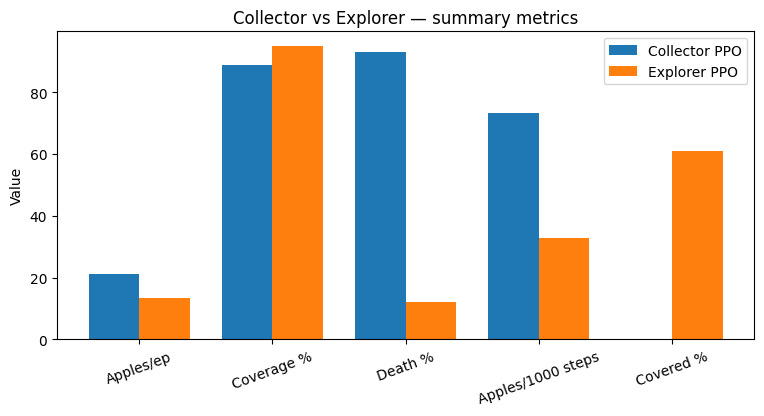

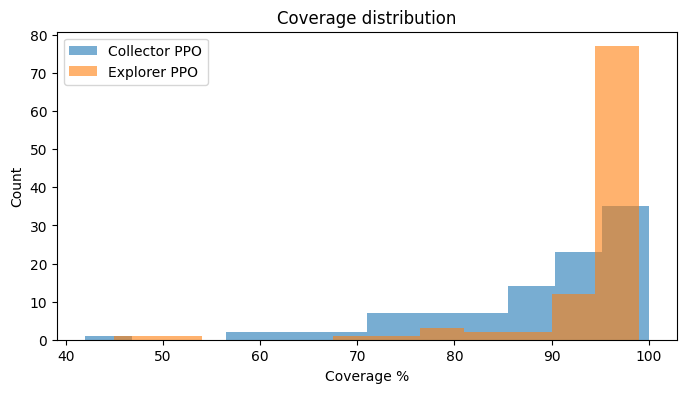

In [46]:
import numpy as np
if "ppo_collector" in dfs and "ppo_explorer" in dfs:
    s = dfs["ppo_collector"]; e = dfs["ppo_explorer"]
    def summ(df):
        return {
            "reward": float(df["reward"].mean()),
            "apples": float(df["apples"].mean()),
            "coverage": float(df["coverage_ratio"].mean()*100.0),
            "death": float(df["died"].mean()*100.0),
            "apples_per_1000": float(df["apples_per_1000_steps"].mean()),
            "covered_rate": float(df["finished_covered"].mean()*100.0),
        }
    S, E = summ(s), summ(e)
    print("Collector(PPO):", S)
    print("Explorer(PPO):", E)

    x = np.arange(5); w = 0.38
    surv_vals = [S["apples"], S["coverage"], S["death"], S["aples_per_1000"] if "aples_per_1000" in S else S["apples_per_1000"], S["covered_rate"]]
    expl_vals = [E["apples"], E["coverage"], E["death"], E["apples_per_1000"], E["covered_rate"]]
    labels = ["Apples/ep","Coverage %","Death %","Apples/1000 steps","Covered %"]

    plt.figure(figsize=(9,4))
    plt.bar(x - w/2, surv_vals, width=w, label="Collector PPO")
    plt.bar(x + w/2, expl_vals, width=w, label="Explorer PPO")
    plt.xticks(x, labels, rotation=20)
    plt.ylabel("Value")
    plt.title("Collector vs Explorer — summary metrics")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.hist(s["coverage_ratio"]*100.0, bins=12, alpha=0.6, label="Collector PPO")
    plt.hist(e["coverage_ratio"]*100.0, bins=12, alpha=0.6, label="Explorer PPO")
    plt.xlabel("Coverage %"); plt.ylabel("Count")
    plt.title("Coverage distribution")
    plt.legend(); plt.show()
else:
    print("Need both ppo_collector and ppo_explorer.")


### Behavioral Insights

#### Reward priorities:

Collector seeks apples efficiently. It’s rewarded heavily for each apple (+10) and lightly penalized for time or death (–0.01 per step, –10 death).

Explorer instead gets steady incremental reward for new-cell coverage and smaller apple bonuses (+2), pushing it toward broad exploration rather than repeated apple collection.

#### Emergent behaviors:

Collector learns tight, systematic foraging loops. Sacrifices map coverage for apple hunting.

Explorer exhibits wide-ranging sweeps that maximize visited tiles, but its curiosity leads to more self-collisions and reduced efficiency at finding apples.

#### Metric patterns:

Collector → High apple count, moderate coverage, high death rate due to aggressive movement and increased length from apples.

Explorer → Fewer apples, very high coverage (≈ 95 %) and better survival rate.

#### Takeaway:

The Collector–Explorer comparison shows how reward shaping defines agent persona:

Collector optimizes short-term, high-value gains (apples).

Explorer optimizes long-term, diverse state discovery (coverage).

## Part 2 — Survivor A2C vs Survivor PPO

PPO Collector: {'reward': 199.59330000000057, 'apples': 21.17, 'coverage': 88.91999999999999, 'death': 93.0, 'apples_per_1000': 73.42745584648193}
A2C Collector: {'reward': 105.12640000000022, 'apples': 11.55, 'coverage': 84.91, 'death': 9.0, 'apples_per_1000': 13.255368161439543}


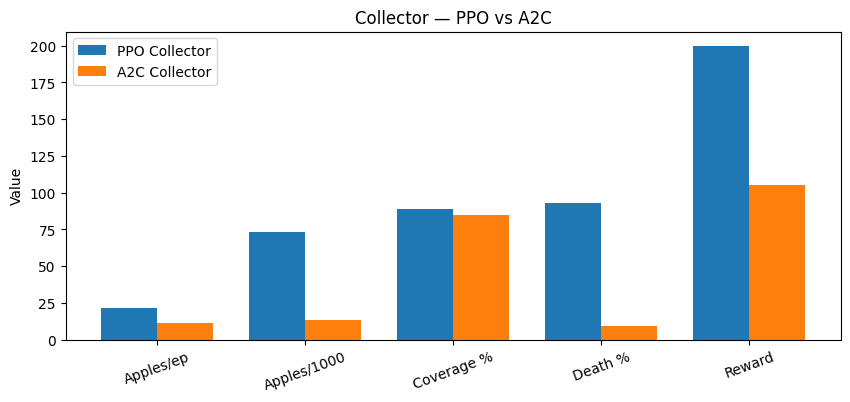

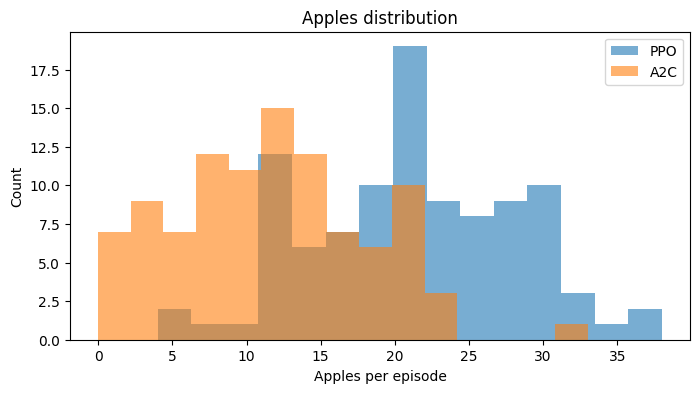

In [49]:

if "ppo_collector" in dfs and "a2c_collector" in dfs:
    p = dfs["ppo_collector"]; a = dfs["a2c_collector"]
    def summ(df):
        return {
            "reward": float(df["reward"].mean()),
            "apples": float(df["apples"].mean()),
            "coverage": float(df["coverage_ratio"].mean()*100.0),
            "death": float(df["died"].mean()*100.0),
            "apples_per_1000": float(df["apples_per_1000_steps"].mean()),
        }
    P, A = summ(p), summ(a)
    print("PPO Collector:", P)
    print("A2C Collector:", A)

    import numpy as np
    x = np.arange(5); w = 0.38
    p_vals = [P["apples"], P["apples_per_1000"], P["coverage"], P["death"], P["reward"]]
    a_vals = [A["apples"], A["apples_per_1000"], A["coverage"], A["death"], A["reward"]]
    labels = ["Apples/ep","Apples/1000","Coverage %","Death %","Reward"]

    plt.figure(figsize=(10,4))
    plt.bar(x - w/2, p_vals, width=w, label="PPO Collector")
    plt.bar(x + w/2, a_vals, width=w, label="A2C Collector")
    plt.xticks(x, labels, rotation=20)
    plt.ylabel("Value")
    plt.title("Collector — PPO vs A2C")
    plt.legend(); plt.show()

    plt.figure(figsize=(8,4))
    plt.hist(p["apples"], bins=15, alpha=0.6, label="PPO")
    plt.hist(a["apples"], bins=15, alpha=0.6, label="A2C")
    plt.xlabel("Apples per episode"); plt.ylabel("Count")
    plt.title("Apples distribution")
    plt.legend(); plt.show()
else:
    print("Need ppo_collector and a2c_collector.")


### Learning Dynamics

PPO (Proximal Policy Optimization) learns robust, exploratory strategies. It updates policies conservatively via clipping, balancing exploitation and exploration.

A2C (Advantage Actor–Critic) is more reactive and synchronous, leading to safer, shorter-horizon decisions.

| Algorithm | Avg Reward | Apples / Ep | Death Rate | Coverage        | Style                       |
| --------- | ---------- | ----------- | ---------- | --------------- | --------------------------- |
| **PPO**   | High       | Highest     | High       | Moderate        | Bold, risk-taking collector |
| **A2C**   | Moderate   | Fewer       | Low        | Slightly higher | Conservative, cautious      |

PPO tends to over-commit to risky apple-hunts, sometimes colliding with a wall or itself afterward. It oscillates longer and finds smaller minimums.

A2C stabilizes faster but plateaus early at local minimums; it avoids danger yet misses apples, and times out.

A2C also took over double the timesteps of PPO to reach similar human-like performance, likely caused by its slower, mnore conservative learning rate.

#### Takeaway
This contrast highlights how algorithm design interacts with reward structure to shape risk appetite and task efficiency.

# Part 3 — Fault Injection: Invisible Wall (Snake)


We evaluate **Survivor (PPO)** and **Explorer (PPO)** under an injected **Invisible Wall** fault and compare to their fault-free baselines.
This reveals each persona’s robustness and failure modes.


In [ ]:


def summarize(df):
    return {
        "mean_reward": float(df["reward"].mean()),
        "death_rate_%": float((df["died"] > 0).mean() * 100.0),
        "apples_per_ep": float(df["apples"].mean()),
        "coverage_%": float(df["coverage_ratio"].mean() * 100.0),
        "wall_hits": float(df["wall_hits"].mean()),
        "self_hits": float(df["self_hits"].mean()),
    }

summary = pd.DataFrame({
    "Collector": summarize(dfs["ppo_collector"]),
    "Collector (Invisible)": summarize(dfs["collector_invis"]),
    "Explorer": summarize(dfs["ppo_explorer"]),
    "Explorer (Invisible)": summarize(dfs["explorer_invis"]),
}).T.round(2)

summary


,mean_reward,death_rate_%,apples_per_ep,coverage_%,wall_hits,self_hits
Collector,199.59,93.0,21.17,88.92,0.02,0.91
Collector (Invisible),153.29,83.0,16.54,75.92,0.11,0.72
Explorer,55.85,12.0,13.50,94.95,0.01,0.11
Explorer (Invisible),34.78,50.0,12.16,86.55,0.18,0.32


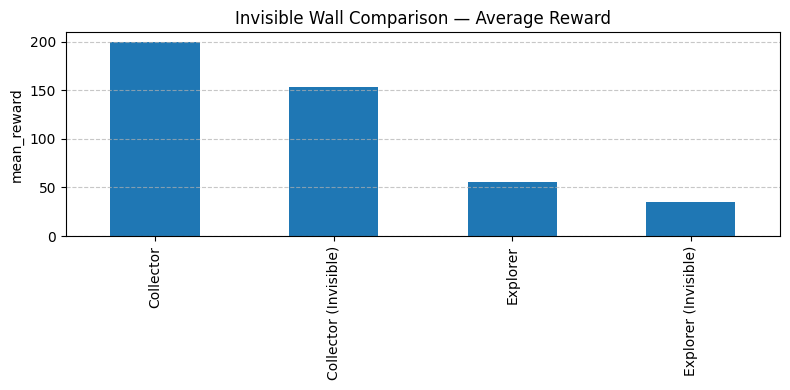

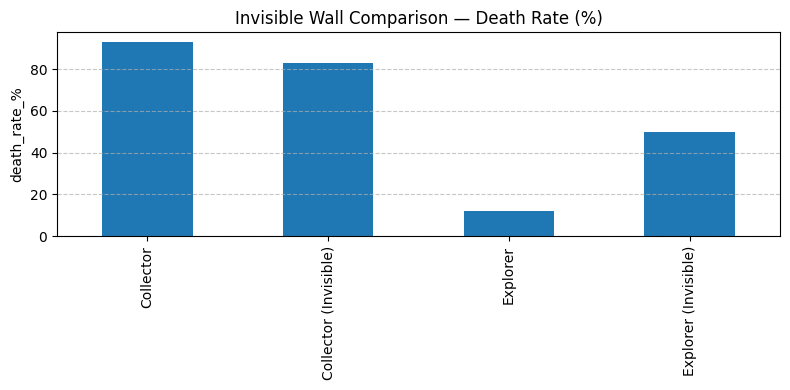

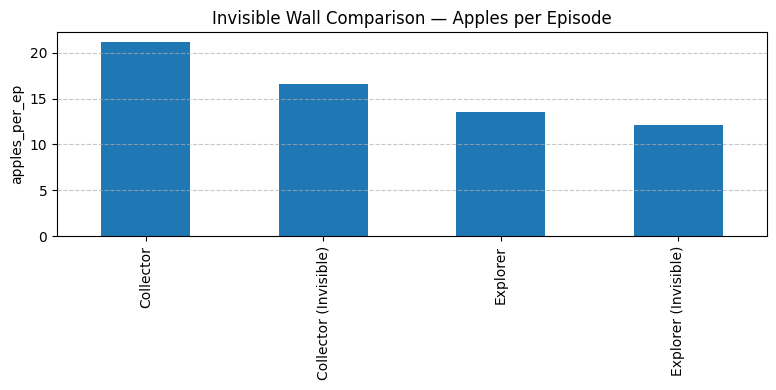

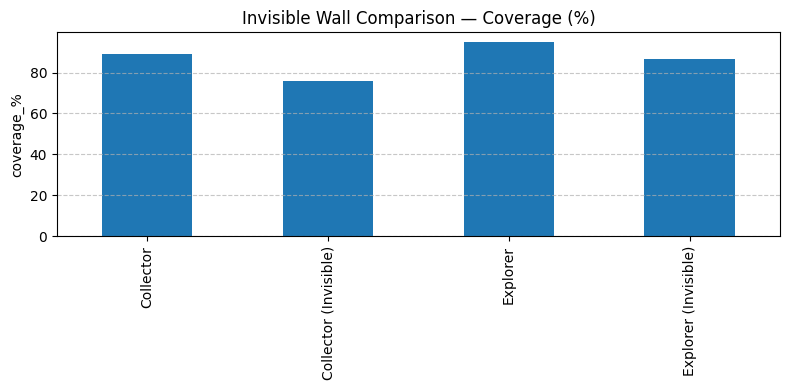

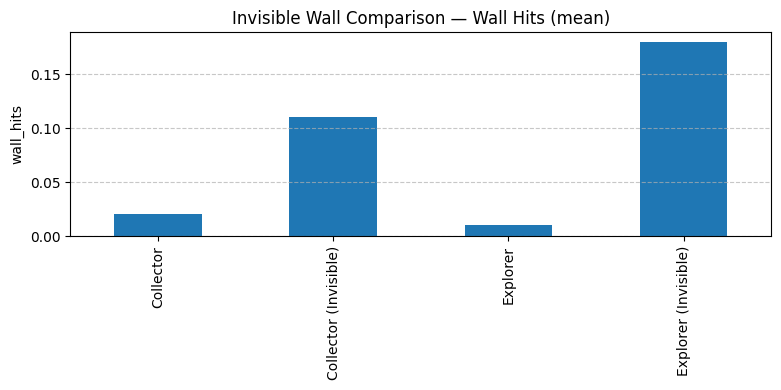

In [ ]:

metrics = [
    ("mean_reward", "Average Reward"),
    ("death_rate_%", "Death Rate (%)"),
    ("apples_per_ep", "Apples per Episode"),
    ("coverage_%", "Coverage (%)"),
    ("wall_hits", "Wall Hits (mean)"),
]


for key, title in metrics:
    plt.figure(figsize=(8,4))
    summary[key].plot(kind="bar")
    plt.title(f"Invisible Wall Comparison — {title}")
    plt.ylabel(key)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()



### Key findings (Invisible Wall)

- Both personas show **lower reward** and **lower coverage** under the invisible-wall fault, and **mean wall hits increase**.
- Collector maintains higher apples/episode despite the fault, but still suffers a drop in reward and coverage.
- Explorer experiences a large **death-rate spike** and notable coverage drop under the fault, which shows fragility when exploration collides with hidden obstacles.
- **Robustness** Survivor is more resilient to hidden obstacles (keeps collecting apples, death rate actually decreases since it tries to avoid the invisible wall). Explorer is more brittle (keeps driving into the invisible barrier because of coverage-seeking).
- **Testing results:** The fault creates a clear signal across metrics (reward, coverage, death rate, wall hits), demonstrating issue detection via rewards. Using multiple personas exposes different failure modes.
